In [5]:
import numpy as np
import uproot
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
from scipy import optimize
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq

In [2]:
from src.process_data import process_data
from src.graph import graph
from src.transmission import transmission

In [3]:
from utils import search_asc, search_desc, xsec_to_ts, tof_to_energy, energy_to_tof, chi_sq

In [6]:
f = open("temp_data/Al.txt")
energy = []
crs = []
for line in f:
    energy.append(float(line[3:14]))
    crs.append(float(line[20:27]))
energy = np.array(energy)
crs = np.array(crs)

In [33]:
tof = energy_to_tof(energy, 182.24, 939.56542, 299792458)[::-1] * 1e9
ts = xsec_to_ts(crs * 1e-28, 9747, 0.03, 3.47e-25)[::-1]

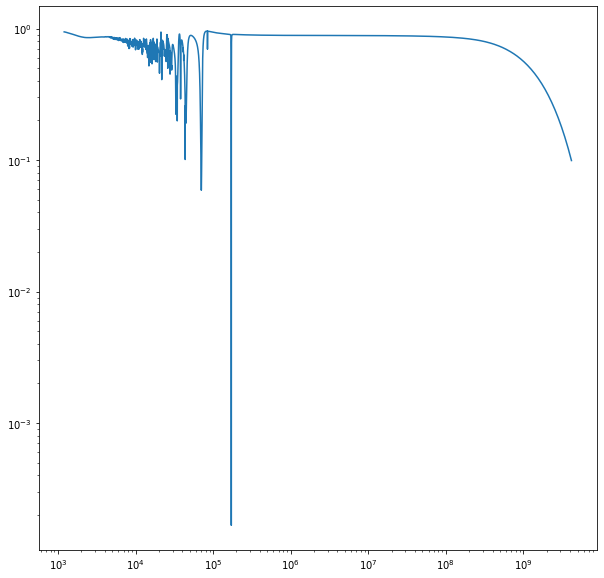

In [34]:
plt.figure(figsize=(10,10))
plt.plot(tof, ts)
plt.xscale('log')
plt.yscale('log')

In [35]:
energy_to_tof(6000 / 1e6, 182.24, 939.56542, 299792458) * 1e9

170097.5166176688

In [46]:
left = search_asc(tof, 171440)
right = search_asc(tof, 171500)

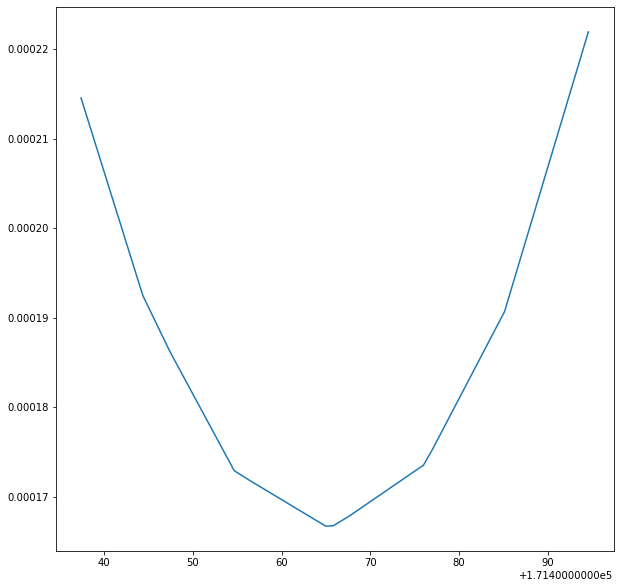

In [47]:
plt.figure(figsize=(10,10))
plt.plot(tof[left:right], ts[left:right])